# Setup

In [1]:
import sys
import pickle
import os

sys.path.append('..')
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

In [2]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [3]:
# A helper function to turn numeric latitudes to into strings
def format_lat(lat):
    return str(-1 * lat) + 'S' if lat < 0 else str(lat) + 'N'

In [4]:
# A helper function to compute all relevant metrics
def build_metric_dict(y_test, y_pred, mape_thresh = 0.5):
    metric_dict = {}

    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
    
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

    return metric_dict

In [5]:
# A helper function to apply preprocessing for a given latitude, both inputs and outputs
def preprocess(inputs, outputs, remove_trend, remove_season):
    pp_data = apply_preprocessing(inputs, mode = 'inputs', remove_season = remove_season,
                                  remove_trend = remove_trend, standardize = True, lowpass = False)
    data_vars = list(pp_data.keys())
    pp_data_np = reshape_inputs(pp_data, keep_coords = ['time'], data_vars = data_vars)

    strength = apply_preprocessing(outputs, mode = 'outputs', remove_season = remove_season,
                                   remove_trend = remove_trend, standardize = False, lowpass = False)
    strength_np = strength.moc.squeeze().values

    X = pp_data_np
    y = strength_np
    
    X = sm.add_constant(X)

    return X, y

# Experiment variables

In [6]:
# Experiment variables
data_home = '/Users/emiliolr/Google Drive/My Drive/GTC'
lat_for_training = -59.75
other_lats = list(np.arange(-70.25, -29.75 + 0.5, 0.5))
other_lats.remove(lat_for_training)

lats = sorted([lat_for_training] + other_lats)

remove_trend = False
remove_season = False

# Experiment 1: transferability to adjacent vs. non-adjacent latitudes
Train on 60S, evaluate on 61S and 30S to see if there is some level of transferability between adjacent latitudes. If there is, this could suggest that characteristics of that latitude that we're not yet capturing (e.g., bathymetry) could be relevant to ensure cross-latitude model transfer.

In [7]:
# Loading surface variables
southern_ocean = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', 'southern_ocean.nc'))
southern_ocean = southern_ocean.sel(latitude = southern_ocean.latitude.isin(lats))
southern_ocean = southern_ocean.fillna(0)
southern_ocean

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 82, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -70.25 -69.75 -69.25 ... -30.75 -30.25 -29.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -1.565 -1.565 ... 0.6051
    ZWS        (time, latitude, longitude) float32 0.03165 0.03165 ... -0.05642
    OBP        (time, latitude, longitude) float32 19.47 19.47 ... 12.21 12.21
    SSS        (time, latitude, longitude) float32 33.29 33.29 ... 35.81 35.81
    SST        (time, latitude, longitude) float32 -1.373 -1.373 ... 21.72 21.72

In [9]:
# Load in response var for all relevant latitudes
moc_all_lats = []

for lat in lats:
    lat_str = format_lat(lat)
    moc_fp = f'{data_home}/ecco_data_minimal/southern_ocean_moc/{lat_str}_moc.pickle'

    with open(moc_fp, 'rb') as f:
        moc = pickle.load(f)

    moc_all_lats.append(moc)

moc_all_lats = np.array(moc_all_lats)
moc_all_lats = xr.Dataset(data_vars = {'moc' : (['latitude', 'time'], moc_all_lats)}, 
                          coords = {'time' : southern_ocean.time, 'latitude' : lats})
moc_all_lats

<xarray.Dataset>
Dimensions:   (latitude: 82, time: 312)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) float64 -70.25 -69.75 -69.25 ... -30.75 -30.25 -29.75
Data variables:
    moc       (latitude, time) float64 -11.32 -12.14 -11.3 ... -20.23 -23.15

In [11]:
# Training a linear regression model on 60S
inputs = southern_ocean.sel(latitude = lat_for_training).expand_dims({'latitude' : 1})
outputs = moc_all_lats.sel(latitude = lat_for_training).expand_dims({'latitude' : 1})

# Preprocessing all inputs
X, y = preprocess(inputs, outputs, remove_trend, remove_season)

#  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                    stratify = None, random_state = 123456)

# Define the hyperparameters to optimize over
param_grid = {
    'alpha' : np.logspace(-4, 4, 10),
    'L1_wt' : np.linspace(0, 1, 10)
}

# TRAINING: grid search with cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv = 10, scoring = 'neg_mean_squared_error', verbose = 1)
grid_search.fit(X_train, y_train)

#  report best result
print(f'Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}')

#  calculate test performance for 60S
y_pred_60S = grid_search.best_estimator_.predict(X_test)
metric_dict_60S = build_metric_dict(y_test, y_pred_60S)
print(metric_dict_60S)

axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best MSE (cross-validation): 15.95
{'R^2': 0.446, 'MSE': 29.862, 'RMSE': 5.465, 'MAE': 4.689, 'MAPE': 85.273, 'MAPE_thresh': '85.266 (thresh=0.5, 100.0% kept)'}


In [15]:
# Extending the 60S model to other 
just_test_period = False
meta_metric_dict = {'RMSE' : [], 'MAE' : [], 'R^2' : [], 'MAPE' : []}

for lat in other_lats:
    print(f'PREDICTING ON LATITUDE {format_lat(lat)}')
    
    X = southern_ocean.sel(latitude = lat).expand_dims({'latitude' : 1})
    y = moc_all_lats.sel(latitude = lat).expand_dims({'latitude' : 1})

    X, y = preprocess(X, y, remove_trend, remove_season)

    y_pred = grid_search.best_estimator_.predict(X)

    if just_test_period:
        metric_dict = build_metric_dict(y[len(X_train) : ], y_pred[len(X_train) : ])
    else:
        metric_dict = build_metric_dict(y, y_pred)
    
    for metric in meta_metric_dict:
        meta_metric_dict[metric].append(metric_dict[metric])

    print('------')

PREDICTING ON LATITUDE 70.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
{'R^2': -5.035, 'MSE': 36.05, 'RMSE': 6.004, 'MAE': 5.341, 'MAPE': 36.864, 'MAPE_thresh': '36.864 (thresh=0.5, 100.0% kept)'}
------
PREDICTING ON LATITUDE 69.75S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
{'R^2': -7.534, 'MSE': 37.978, 'RMSE': 6.163, 'MAE': 5.567, 'MAPE': 38.178, 'MAPE_thresh': '38.178 (thresh=0.5, 100.0% kept)'}
------
PREDICTING ON LATITUDE 69.25S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
{'R^2': -7.416, 'MSE': 43.41, 'RMSE': 6.589, 'MAE': 6.052, 'MAPE': 40.607, 'MAPE_thresh': '40.607 (thresh=0.5, 100.0% kept)'}
------
PREDICTING ON LATITUDE 68.75S
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
{'R^2': -7.031, 'MSE': 50.006, 'RMSE': 7.071, 'MAE': 6.576, 'MAPE': 42.753, 'MAPE_thresh': '42.753 (thresh=0.5, 100.0% kept)

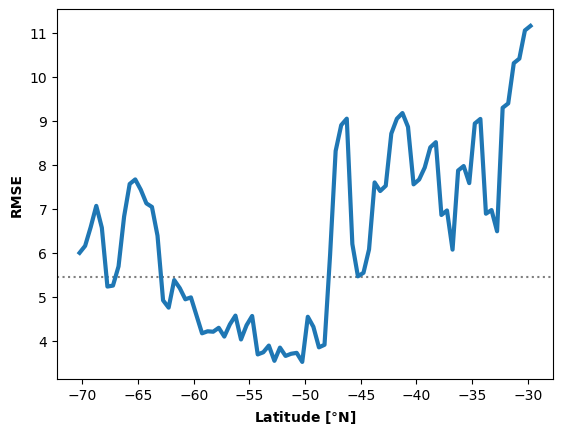

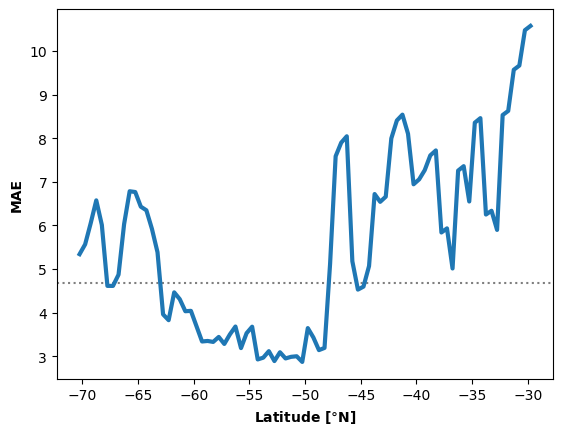

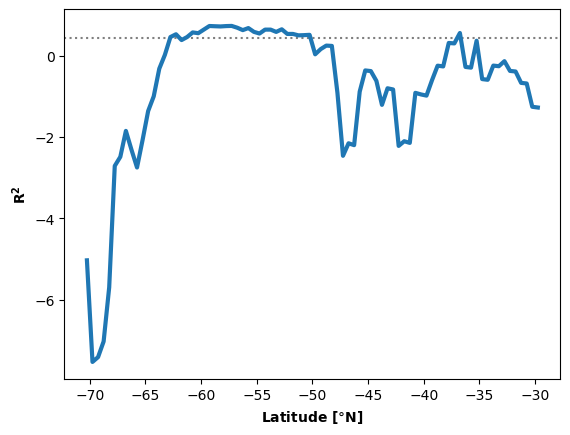

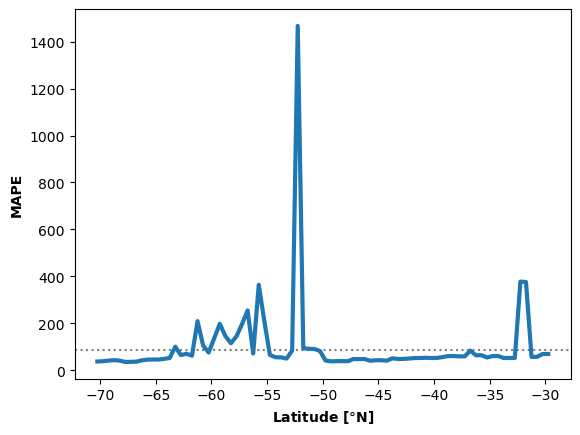

In [21]:
# Plotting the performance as a function of latitude in the southern ocean
for metric in meta_metric_dict:
    plt.axhline(metric_dict_60S[metric], linestyle = ':', color = 'black', alpha = 0.5, zorder = 0)
    plt.plot(other_lats, meta_metric_dict[metric], linewidth = 3, zorder = 50)
    
    plt.xlabel('Latitude [$\\degree$N]', weight = 'bold')
    plt.ylabel(metric if metric != 'R^2' else 'R$\\mathbf{^2}$', weight = 'bold')

    plt.savefig(f'/Users/emiliolr/Desktop/linear_regression_transfer_{metric}.png', bbox_inches = 'tight')
    plt.show()

# Experiment 2: training independently on each latitude
Checking performance vs. latitude when training/testing independently on each latitude.

In [18]:
# Getting surface vars for all lats
southern_ocean = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', 'southern_ocean.nc'))
southern_ocean = southern_ocean.dropna('latitude', how = 'all')
southern_ocean = southern_ocean.fillna(0)

lats = southern_ocean.latitude.values

# Getting streamfunc for all lats
moc_all_lats = []

for lat in lats:
    lat_str = format_lat(lat)
    moc_fp = f'{data_home}/ecco_data_minimal/southern_ocean_moc/{lat_str}_moc.pickle'

    with open(moc_fp, 'rb') as f:
        moc = pickle.load(f)

    moc_all_lats.append(moc)

moc_all_lats = np.array(moc_all_lats)
moc_all_lats = xr.Dataset(data_vars = {'moc' : (['latitude', 'time'], moc_all_lats)}, 
                          coords = {'time' : southern_ocean.time, 'latitude' : lats})

In [40]:
# Training a linear regression on each lat independently
meta_metric_dict = {'RMSE' : [], 'MAE' : [], 'R^2' : [], 'MAPE' : []}

for lat in lats:
    print(f'Training on {format_lat(lat)}...')
    
    inputs = southern_ocean.sel(latitude = lat).expand_dims({'latitude' : 1})
    outputs = moc_all_lats.sel(latitude = lat).expand_dims({'latitude' : 1})
    
    # Preprocessing all inputs
    X, y = preprocess(inputs, outputs, remove_trend, remove_season)
    
    #  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                        stratify = None, random_state = 123456)
    
    # Define the hyperparameters to optimize over
    param_grid = {
        'alpha' : np.logspace(-4, 4, 10),
        'L1_wt' : np.linspace(0, 1, 10)
    }
    
    # TRAINING: grid search with cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv = 10, scoring = 'neg_mean_squared_error', verbose = 0)
    grid_search.fit(X_train, y_train)
    
    #  calculate test performance for 60S
    y_pred = grid_search.best_estimator_.predict(X_test)
    metric_dict = build_metric_dict(y_test, y_pred)

    #  add to collection of metric dictionaries
    for metric in meta_metric_dict:
        meta_metric_dict[metric].append(metric_dict[metric])

    print('------')

Training on 80.25S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)


/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


------
Training on 79.75S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)


/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliolr/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


------
Training on 79.25S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 78.75S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 78.25S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 77.75S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 77.25S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 76.75S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 76.25S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 75.75S...
axes: ['time', 'feature']
variables: ['SSH', 'ZWS', 'OBP', 'SSS', 'SST']
shape: (312, 5)
------
Training on 75.25S...
axes: ['time', 'feature']
v

In [41]:
# Saving results just in case, since the last cell takes a long time to run
fp = '/Users/emiliolr/Desktop/performance_vs_latitude_linear_regression.pickle'
with open(fp, 'wb') as f:
    pickle.dump(meta_metric_dict, f)

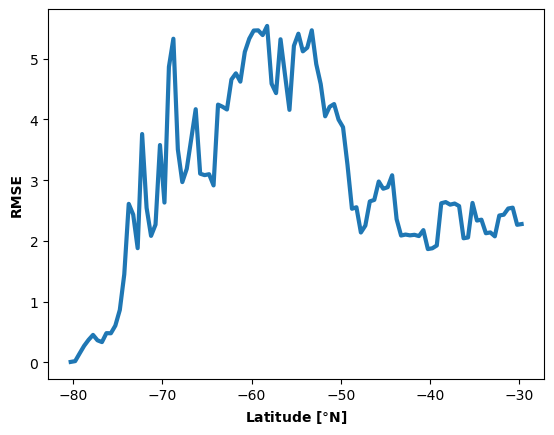

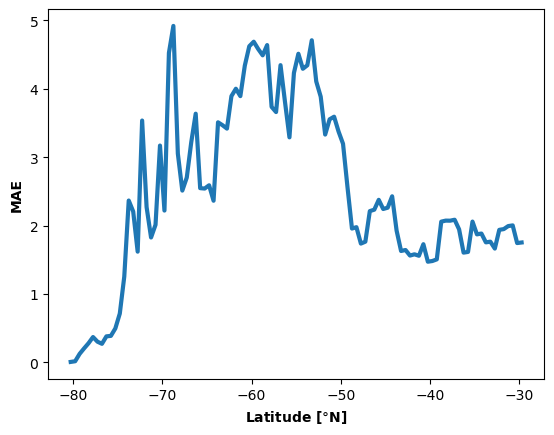

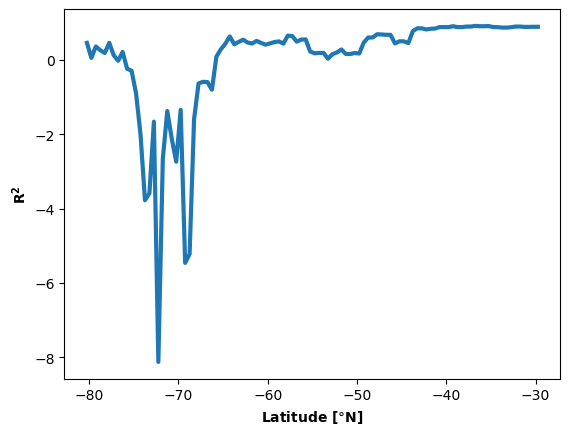

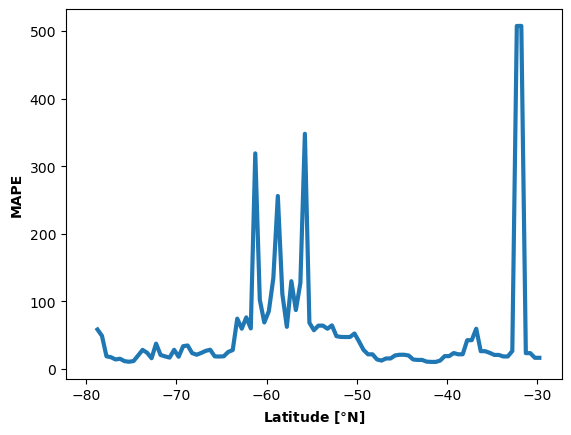

In [44]:
# Plotting the performance as a function of latitude in the southern ocean
with open(fp, 'rb') as f:
    meta_metric_dict = pickle.load(f)

for metric in meta_metric_dict:
    meta_metric_dict[metric] = np.array(meta_metric_dict[metric])
    if metric == 'MAPE':
        meta_metric_dict[metric][meta_metric_dict[metric] > 1000] = np.nan
    
    plt.plot(lats, meta_metric_dict[metric], linewidth = 3)
    
    plt.xlabel('Latitude [$\\degree$N]', weight = 'bold')
    plt.ylabel(metric if metric != 'R^2' else 'R$\\mathbf{^2}$', weight = 'bold')

    plt.savefig(f'/Users/emiliolr/Desktop/linear_regression_all_lats_{metric}.png', bbox_inches = 'tight')
    plt.show()

# Testing

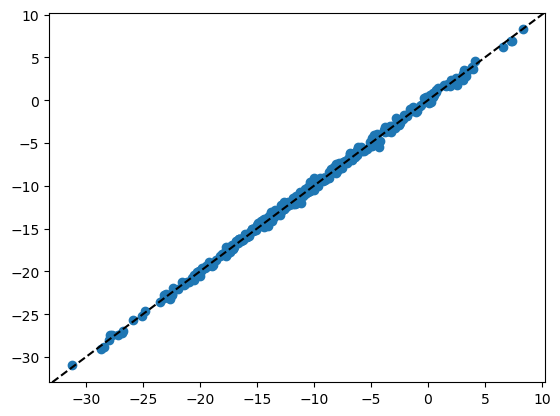

In [77]:
lat = '60S'
mocB_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(mocB_fp, 'rb') as f:
    mocB = pickle.load(f)

plt.axline((0, 0), slope = 1, linestyle = '--', color = 'black')
plt.scatter(mocB, moc_all_lats.sel(latitude = -59.75).moc.values);